# UAS PENGANTAR DATA MINING



*   **Nama          : Kevin Pratama**
*   **Nim           : 41522010042**
*   **Kelas         : T-003**
*   **Waktu         : Senin, 10:15-12:45**
*  **Dosen Pengampu : Hery Derajad Wijaya, S.Kom, MM**





# Penerapan Model Klasifikasi untuk Memprediksi Kualitas Udara Berdasarkan Polutan dan Faktor Lingkungan
## Business Understanding

Masalah utama yang ingin diselesaikan adalah:

1. Bagaimana kita dapat mengidentifikasi faktor-faktor utama yang memengaruhi kualitas udara di suatu wilayah?
  * Faktor ini mencakup polutan tertentu, parameter lingkungan seperti suhu dan kelembapan, serta aspek demografi seperti kepadatan penduduk.
2. Bagaimana memprediksi kategori kualitas udara berdasarkan data yang tersedia?
  


###Tujuan
* Membangun model klasifikasi (random forest & support vector machine) kualitas udara: Model ini akan menggunakan data parameter polusi (PM2.5, PM10, NO2, SO2, CO), faktor lingkungan (Temperature, Humidity), serta data demografi dan kedekatan dengan kawasan industri untuk memprediksi kategori kualitas udara.
* Mengidentifikasi faktor-faktor signifikan, mlelaui Analisis data akan memberikan insight tentang faktor apa saja yang paling memengaruhi kualitas udara sehingga dapat digunakan untuk merancang intervensi yang lebih efektif.
* perbandingan kinerja antara kedua model random forest & suppoer vector machine



## Import Library/Package yang dibutuhkan

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

## Data Understanding



**Explore Data**

In [2]:
# Load dataset
file_path = "/content/pollution_dataset.csv"
df = pd.read_csv(file_path, delimiter=";")

# Rename columns
df.columns = [
    "Temperature", "Humidity", "PM2.5", "PM10", "NO2", "SO2", "CO",
    "Proximity_to_Industrial_Areas", "Population_Density", "Air_Quality"
]

# 1. Dimensi Dataset
print("Dataset Shape:", df.shape)
# 2. Kolom-kolom yang Tersedia
print("Columns:", df.columns)
# 3. Informasi Tipe Data dan Nilai Null
print(df.info())


Dataset Shape: (5000, 10)
Columns: Index(['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO',
       'Proximity_to_Industrial_Areas', 'Population_Density', 'Air_Quality'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air_Quality           

**Insight:**

* Temperature (float64): Suhu lingkungan.
* Humidity (float64): Tingkat kelembapan.
* PM2.5 (float64): Konsentrasi partikel halus dengan diameter kurang dari 2.5 mikrometer di udara.
* PM10 (float64): Konsentrasi partikel kasar dengan diameter kurang dari 10 mikrometer di udara.
* NO2 (float64): Konsentrasi nitrogen dioksida dalam udara.
* SO2 (float64): Konsentrasi sulfur dioksida dalam udara.
* CO (float64): Konsentrasi karbon monoksida dalam udara.
* Proximity_to_Industrial_Areas (float64): Kedekatan lokasi dengan kawasan industri dalam satuan tertentu.
* Population_Density (int64): Kepadatan populasi pada suatu lokasi (kemungkinan dalam jumlah individu per km²).
* Air_Quality (object): Label kategori yang menggambarkan kualitas udara.




**Memahami fitur**

In [3]:
# Menampilkan statistik deskriptif untuk semua kolom
print(df.describe(include='all'))


        Temperature     Humidity        PM2.5         PM10          NO2  \
count   5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
unique          NaN          NaN          NaN          NaN          NaN   
top             NaN          NaN          NaN          NaN          NaN   
freq            NaN          NaN          NaN          NaN          NaN   
mean      30.029020    70.056120    20.142140    30.218360    26.412100   
std        6.720661    15.863577    24.554546    27.349199     8.895356   
min       13.400000    36.000000     0.000000    -0.200000     7.400000   
25%       25.100000    58.300000     4.600000    12.300000    20.100000   
50%       29.000000    69.800000    12.000000    21.700000    25.300000   
75%       34.000000    80.300000    26.100000    38.100000    31.900000   
max       58.600000   128.100000   295.000000   315.800000    64.900000   

                SO2           CO  Proximity_to_Industrial_Areas  \
count   5000.000000  5000.000000

**Insight**

1. **Temperature**
   - Suhu rata-rata adalah **30.03°C** dengan variasi yang cukup besar (**13.4°C hingga 58.6°C**).
   - Sebagian besar suhu berada dalam rentang **25.1°C hingga 34.0°C**, menunjukkan kondisi lingkungan yang umumnya hangat.
   - Suhu maksimum **58.6°C** tampak ekstrem dan mungkin perlu divalidasi apakah ini merupakan outlier atau data sebenarnya.

1. **Humidity**
   - Kelembapan rata-rata cenderung tinggi (**70.06%**) dan cukup bervariasi (**36% hingga 128.1%**).
   - Nilai kelembapan >100% tampak tidak realistis dan kemungkinan merupakan kesalahan pengukuran atau outlier yang perlu diperiksa dan ditangani.

2. **Polusi Udara**
   - **PM2.5 dan PM10** memiliki distribusi yang sangat bervariasi. Banyak nilai tinggi, termasuk outlier (misalnya PM2.5 hingga **295 µg/m³** dan PM10 hingga **315.8 µg/m³**), yang menunjukkan potensi masalah polusi udara serius di beberapa area.
   - Nilai negatif pada **PM10 (-0.2 µg/m³)** adalah kesalahan data atau pengukuran dan harus diperbaiki.

3. **Konsentrasi NO2**
   - Konsentrasi **NO2** bervariasi antara **7.4 hingga 64.9 µg/m³**, dengan rata-rata **26.41 µg/m³**.
   - Meski variasinya lebih rendah dibandingkan PM2.5 dan PM10, ada lokasi dengan konsentrasi NO2 yang cukup tinggi.

4. **Konsentrasi SO2**
   - Konsentrasi **SO2** rata-rata **10.01 µg/m³** relatif rendah dibandingkan polutan lainnya.
   - Namun, terdapat nilai negatif (-6.2 µg/m³), yang menunjukkan kemungkinan kesalahan pengukuran atau anomali yang perlu diperbaiki.

5. **Konsentrasi CO**
   - Konsentrasi **CO** memiliki rata-rata **1.5 ppm** dengan variasi yang relatif kecil (**0.65 hingga 3.72 ppm**).
   - Hal ini menunjukkan bahwa polusi karbon monoksida relatif terkendali dibandingkan dengan polutan lainnya.

6. **Proksimitas ke Kawasan Industri**
   - Proximity ke kawasan industri bervariasi dari **2.5 hingga 25.8 (skala tertentu)**, dengan rata-rata **8.43**.
   - Lokasi yang lebih dekat ke kawasan industri mungkin lebih terpengaruh oleh polusi, sehingga faktor ini penting untuk dianalisis lebih lanjut.

7. **Kepadatan Penduduk**
   - Kepadatan penduduk sangat bervariasi (**188 hingga 957 orang/km²**), dengan rata-rata **497 orang/km²**.
   - Wilayah dengan kepadatan tinggi mungkin lebih rentan terhadap kualitas udara buruk akibat aktivitas manusia.

8. **Kualitas Udara**
   - Sebagian besar data menunjukkan kualitas udara **"Good"** (2000 dari 5000 pengamatan).

**Memeriksa Variabel Target**

In [4]:
# Melihat distribusi kategori 'Air Quality'
print(df["Air_Quality"].value_counts())

Air_Quality
Good         2000
Moderate     1500
Poor         1000
Hazardous     500
Name: count, dtype: int64


**Insight:**

dari hasil di atas dapat dilihat bahwa Kategori Good mendominasi dengan 2000 data (40% dari total data), Kategori Moderate memiliki 1500 data (30% dari total data), Kategori Poor memiliki 1000 data (20% dari total data), Kategori Hazardous memiliki 500 data (10% dari total data). Distribusi tersebut menunjukan bahwa pada Kategori "Poor" dan "Hazardous" harus dilakukan "weighting" atau "oversampling" dalam model yang digunakan.

**Memeriksa duplikat**

In [5]:
# Menampilkan jumlah baris duplikat
print("Duplicate Rows:", df.duplicated().sum())

Duplicate Rows: 0


**Insight:**

dari hasil di atas dapat dilihat tidak terdapat baris duplikat.

**Checking Outliers**

In [6]:
# Fungsi untuk mendeteksi outlier menggunakan IQR
def detect_outliers_iqr(df):
    outliers = pd.DataFrame(columns=df.columns)

    for column in df.select_dtypes(include=np.number).columns:  # hanya untuk kolom numerik
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_column = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        outliers[column] = outliers_column[column]

    return outliers

# Deteksi outlier menggunakan IQR
outliers_iqr = detect_outliers_iqr(df)
print("Jumlah outlier per kolom menggunakan IQR:")
print(outliers_iqr.count())

Jumlah outlier per kolom menggunakan IQR:
Temperature                      72
Humidity                          1
PM2.5                            20
PM10                             21
NO2                               9
SO2                              12
CO                                7
Proximity_to_Industrial_Areas     0
Population_Density                0
Air_Quality                       0
dtype: int64


**Insight:**


Seperti yang dilihat outliers hanya terdapat pada 7 fitur

**Visualisasi Data**

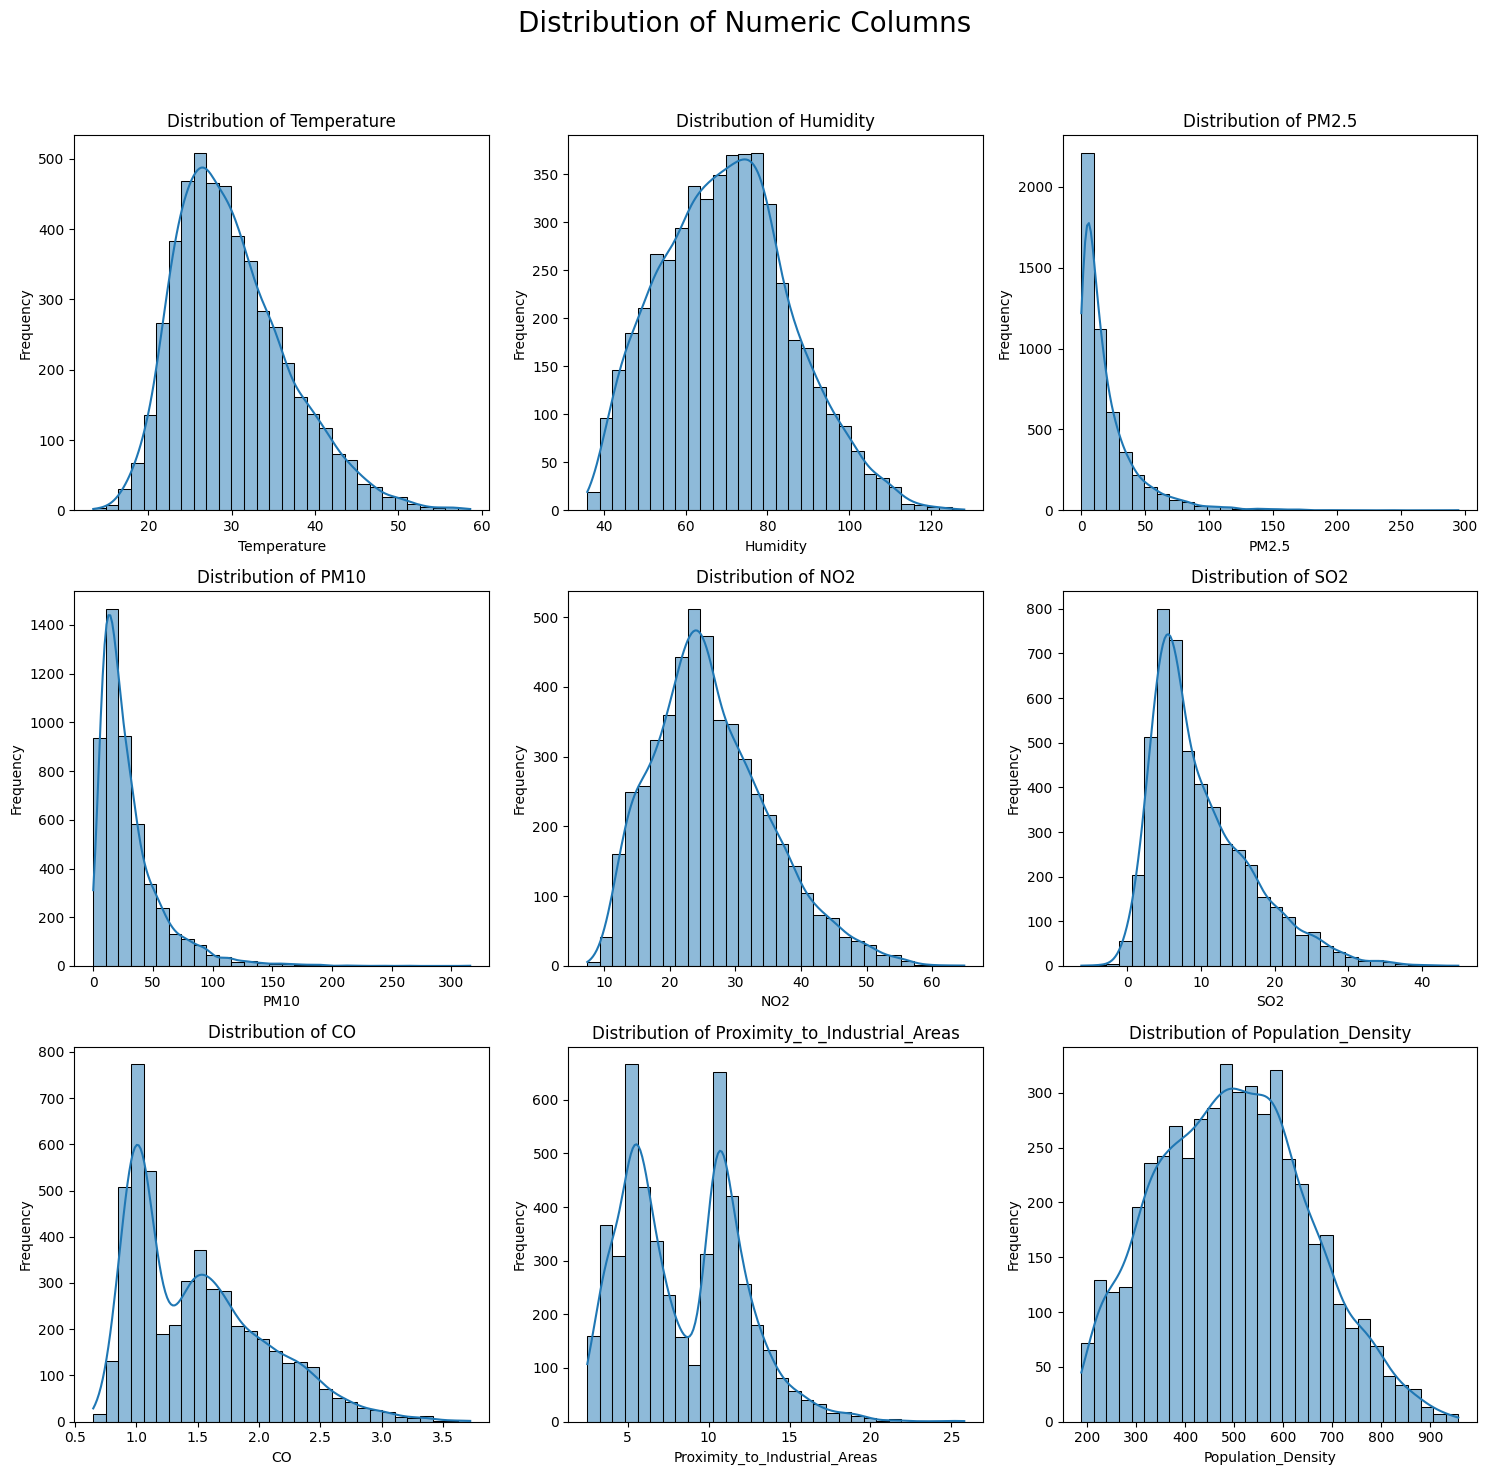

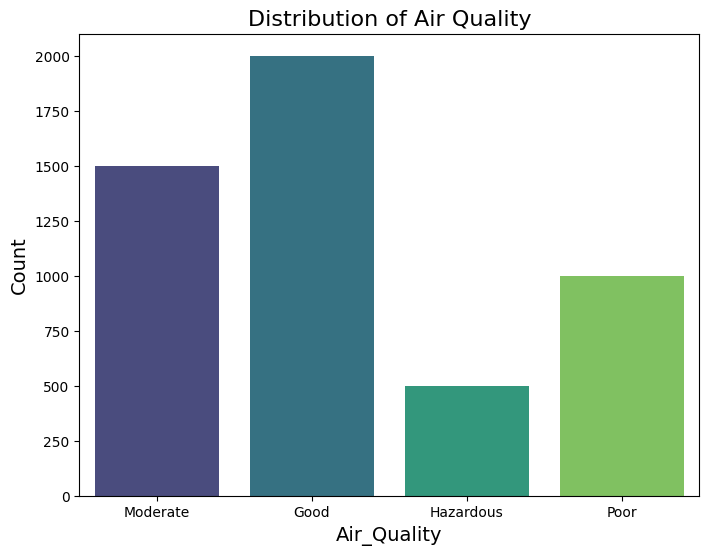

In [7]:
# List of numeric columns
numeric_columns = [
    "Temperature", "Humidity", "PM2.5", "PM10", "NO2",
    "SO2", "CO", "Proximity_to_Industrial_Areas", "Population_Density"
]

# Setting up a grid for small visualizations
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle("Distribution of Numeric Columns", fontsize=20)

# Plotting each numeric column in the grid
for col, ax in zip(numeric_columns, axes.flatten()):
    sns.histplot(df[col], kde=True, bins=30, ax=ax)
    ax.set_title(f"Distribution of {col}", fontsize=12)
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel("Frequency", fontsize=10)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Visualizing Air Quality Distribution separately
plt.figure(figsize=(8, 6))
sns.countplot(x="Air_Quality", data=df, hue="Air_Quality", palette="viridis", legend=False)
plt.title("Distribution of Air Quality", fontsize=16)
plt.xlabel("Air_Quality", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()


**Insight:**

* Karena distribusi mendekati normal, dengan batas berdasarkan nilai median (misalnya, 30°C).

* Kelembapan yang mendekati distribusi normal mempermudah model dalam menentukan batasan split berdasarkan kategori. Misalnya, kelembapan yang sangat tinggi (>80%) dapat memengaruhi akumulasi polutan tertentu seperti PM2.5, sehingga membantu memperjelas keputusan klasifikasi.

* Sebagai salah satu indikator utama kualitas udara, nilai PM2.5 yang skewed ke kanan menandakan perlunya preprocessing (seperti log transformation) agar data lebih seimbang.

* Mirip dengan PM2.5, distribusi PM10 yang skewed ke kanan menandakan bahwa polusi partikel besar cenderung berada pada level rendah. Preprocessing untuk mengatasi skewness dapat membantu meningkatkan akurasi model.

* Nilai NO2 sering muncul di kisaran 20–30 μg/m³, sehingga dapat digunakan untuk memisahkan kategori udara baik (Good) dengan sedang (Moderate).

* Dengan distribusi yang skewed ke kanan, SO2 dapat digunakan pada node lebih lanjut untuk mendeteksi wilayah dengan kualitas udara rendah. Preprocessing mungkin diperlukan untuk membantu model memahami distribusi ini secara lebih efektif.

* CO memiliki pola distribusi yang konsisten, sehingga dapat menjadi indikator yang stabil dalam pemisahan node. Kategori rendah CO biasanya mendukung prediksi kategori kualitas udara "Good" atau "Moderate".

* Wilayah dengan kedekatan tinggi ke kawasan industri biasanya memiliki kualitas udara lebih buruk, sehingga variabel ini dapat langsung memisahkan kategori "Poor" atau "Hazardous" dari kategori lainnya.

* Kepadatan populasi dapat menjadi faktor penting dalam kualitas udara. Wilayah dengan kepadatan tinggi (>600 orang/km²) cenderung memiliki lebih banyak emisi (dari kendaraan, aktivitas rumah tangga, dll.), yang membantu model memisahkan kategori "Moderate" atau lebih buruk.

* Pola distribusi kategori (mayoritas "Good" dan "Moderate") menunjukkan ketidakseimbangan data yang perlu ditangani. Teknik seperti oversampling pada kategori "Hazardous" atau penyesuaian weight dapat membantu Decision Tree memahami kategori minoritas secara lebih efektif.

**Kesimpulan dari Data Understanding:**

data preparation yang perlu dilakukan dari pemahaman yang didapat dari data understanding:

* Fitur seperti PM2.5, PM10, dan Population_Density memerlukan penanganan outlier, seperti menggunakan Winsorization atau memotong data yang berada di luar rentang tertentu.
Normalisasi atau Standarisasi

* Perbedaan skala antar fitur ( Proximity_to_Industrial_Areas jauh lebih besar dibandingkan dengan CO) menunjukkan kebutuhan untuk standarisasi data (z-score normalization) agar model dapat memberikan bobot yang adil ke semua fitur.

* Fitur yang sangat skewed (misalnya, PM2.5 dan PM10) dapat ditransformasi logaritmik atau sqrt untuk membuat distribusinya lebih normal.

## Data Preparation

In [8]:
# 1. Log Transformation untuk PM2.5, PM10, dan SO2
df['PM2.5'] = np.log1p(df['PM2.5'])
df['PM10'] = np.log1p(df['PM10'])
df['SO2'] = np.log1p(df['SO2'])

# 2. Menangani Outlier dengan IQR (menghapus baris dengan outlier)
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Kolom yang memiliki outlier
outlier_columns = ['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO']
df = remove_outliers(df, outlier_columns)

# 3. Normalisasi dan Standardisasi fitur numerik
scaler = StandardScaler()
df[['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO',
    'Proximity_to_Industrial_Areas', 'Population_Density']] = scaler.fit_transform(
    df[['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO',
        'Proximity_to_Industrial_Areas', 'Population_Density']])

# 4. Encoding target variabel 'Air_Quality'
encoder = LabelEncoder()
df['Air_Quality'] = encoder.fit_transform(df['Air_Quality'])

# 5. Menangani ketidakseimbangan kelas dengan SMOTE
X = df.drop('Air_Quality', axis=1)
y = df['Air_Quality']

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 6. Pembagian data untuk training dan testing
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Output untuk memastikan preprocessing telah dilakukan dengan benar
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (6256, 9)
Testing data shape: (1564, 9)


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


**Insight**

setalah melawati data preparation data training menjadi 6256 dan data testing 1564 di sebabkan oleh penggunaan SMOTE (Synthetic Minority Oversampling Technique) dalam langkah penanganan ketidakseimbangan kelas.

##Modelling

**Support Vector Machine**

In [9]:
# Membuat model Support Vector Machine
svm_model = SVC(random_state=42)

# Melatih model menggunakan data training
svm_model.fit(X_train, y_train)

#prediksi data training
y_train_pred_svm = svm_model.predict(X_train)

# Prediksi data testing
y_pred_svm = svm_model.predict(X_test)


**Random Forest**

In [10]:
# Membuat model Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Melatih model menggunakan data training
rf_model.fit(X_train, y_train)

#prediksi data training
y_train_pred_rf = rf_model.predict(X_train)

# Prediksi data testing
y_pred_rf = rf_model.predict(X_test)


## Evaluation

**Evaluasi model SVM**

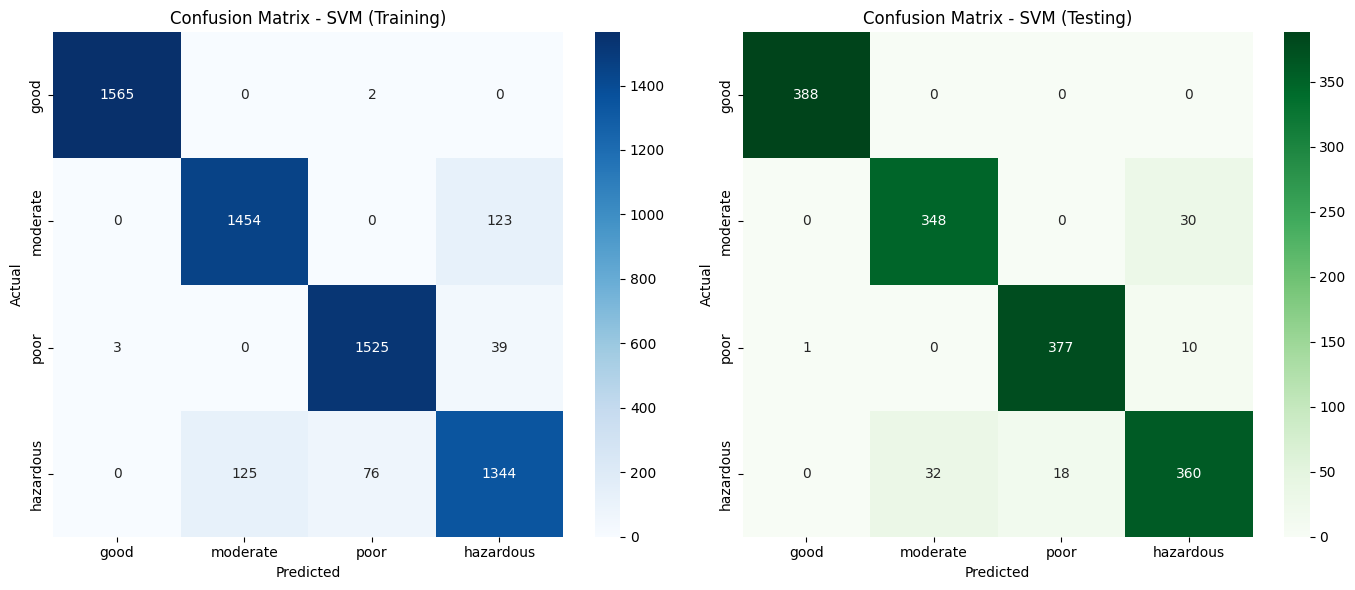

Evaluasi Model SVM pada Data Training:
              precision    recall  f1-score   support

        good       1.00      1.00      1.00      1567
    moderate       0.92      0.92      0.92      1577
        poor       0.95      0.97      0.96      1567
   hazardous       0.89      0.87      0.88      1545

    accuracy                           0.94      6256
   macro avg       0.94      0.94      0.94      6256
weighted avg       0.94      0.94      0.94      6256


Evaluasi Model SVM pada Data Testing:
              precision    recall  f1-score   support

        good       1.00      1.00      1.00       388
    moderate       0.92      0.92      0.92       378
        poor       0.95      0.97      0.96       388
   hazardous       0.90      0.88      0.89       410

    accuracy                           0.94      1564
   macro avg       0.94      0.94      0.94      1564
weighted avg       0.94      0.94      0.94      1564



In [11]:
# Definisikan label untuk klasifikasi
labels = ['good', 'moderate', 'poor', 'hazardous']

# Setup subplot untuk menampilkan confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix (Training)
sns.heatmap(confusion_matrix(y_train, y_train_pred_svm, labels=range(len(labels))),
            annot=True, fmt="d", cmap="Blues", ax=axes[0], xticklabels=labels, yticklabels=labels)
axes[0].set_title("Confusion Matrix - SVM (Training)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Confusion Matrix (Testing)
sns.heatmap(confusion_matrix(y_test, y_pred_svm, labels=range(len(labels))),
            annot=True, fmt="d", cmap="Greens", ax=axes[1], xticklabels=labels, yticklabels=labels)
axes[1].set_title("Confusion Matrix - SVM (Testing)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# Menampilkan plot
plt.tight_layout()
plt.show()

# Mencetak Classification Report untuk SVM (Training)
print("Evaluasi Model SVM pada Data Training:")
print(classification_report(y_train, y_train_pred_svm, target_names=labels))

# Mencetak Classification Report untuk SVM (Testing)
print("\nEvaluasi Model SVM pada Data Testing:")
print(classification_report(y_test, y_pred_svm, target_names=labels))

**Evaluasi model Random Forest**

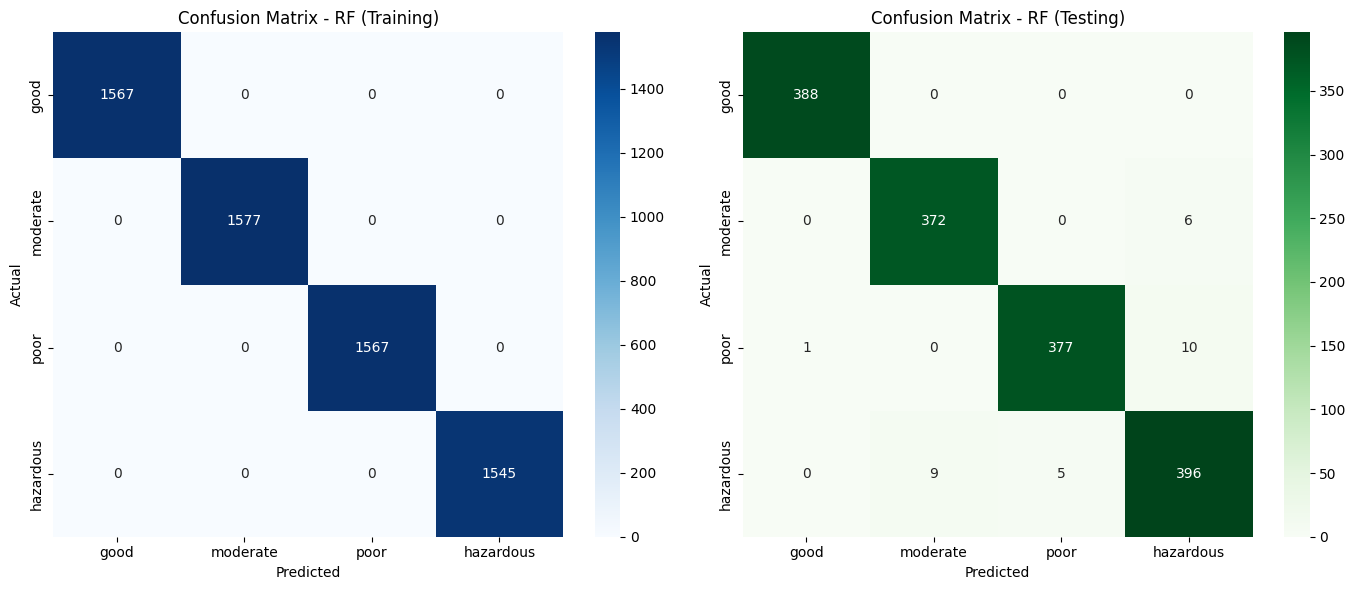

Evaluasi Model RF pada Data Training:
              precision    recall  f1-score   support

        good       1.00      1.00      1.00      1567
    moderate       1.00      1.00      1.00      1577
        poor       1.00      1.00      1.00      1567
   hazardous       1.00      1.00      1.00      1545

    accuracy                           1.00      6256
   macro avg       1.00      1.00      1.00      6256
weighted avg       1.00      1.00      1.00      6256


Evaluasi Model RF pada Data Testing:
              precision    recall  f1-score   support

        good       1.00      1.00      1.00       388
    moderate       0.98      0.98      0.98       378
        poor       0.99      0.97      0.98       388
   hazardous       0.96      0.97      0.96       410

    accuracy                           0.98      1564
   macro avg       0.98      0.98      0.98      1564
weighted avg       0.98      0.98      0.98      1564



In [12]:
# Definisikan label untuk klasifikasi
labels = ['good', 'moderate', 'poor', 'hazardous']

# Setup subplot untuk menampilkan confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix (Training)
sns.heatmap(confusion_matrix(y_train, y_train_pred_rf, labels=range(len(labels))),
            annot=True, fmt="d", cmap="Blues", ax=axes[0], xticklabels=labels, yticklabels=labels)
axes[0].set_title("Confusion Matrix - RF (Training)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Confusion Matrix (Testing)
sns.heatmap(confusion_matrix(y_test, y_pred_rf, labels=range(len(labels))),
            annot=True, fmt="d", cmap="Greens", ax=axes[1], xticklabels=labels, yticklabels=labels)
axes[1].set_title("Confusion Matrix - RF (Testing)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# Menampilkan plot
plt.tight_layout()
plt.show()

# Mencetak Classification Report untuk RF (Training)
print("Evaluasi Model RF pada Data Training:")
print(classification_report(y_train, y_train_pred_rf, target_names=labels))

# Mencetak Classification Report untuk RF (Testing)
print("\nEvaluasi Model RF pada Data Testing:")
print(classification_report(y_test, y_pred_rf, target_names=labels))

**Akurasi Model**

Akurasi SVM (Training): 0.9411764705882353
Akurasi SVM (Testing): 0.9418158567774936
Akurasi RF (Training): 1.0
Akurasi RF (Testing): 0.9801790281329923


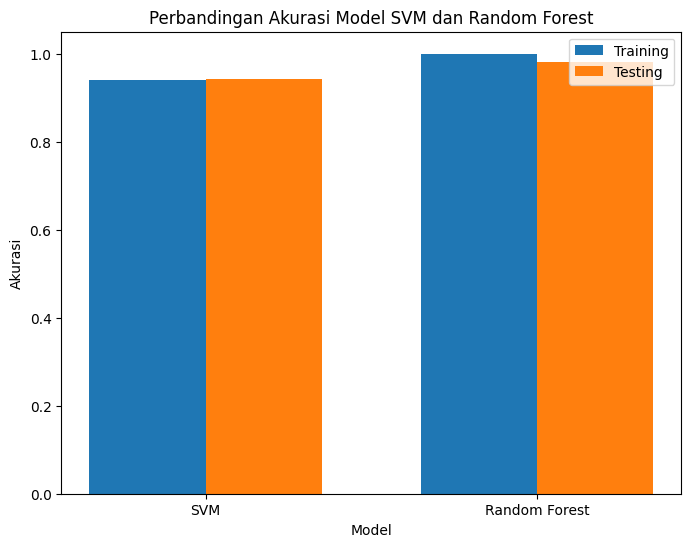

In [13]:
# Akurasi Model
accuracy_svm_train = accuracy_score(y_train, y_train_pred_svm)
accuracy_svm_test = accuracy_score(y_test, y_pred_svm)
accuracy_rf_train = accuracy_score(y_train, y_train_pred_rf)
accuracy_rf_test = accuracy_score(y_test, y_pred_rf)

print(f"Akurasi SVM (Training): {accuracy_svm_train}")
print(f"Akurasi SVM (Testing): {accuracy_svm_test}")
print(f"Akurasi RF (Training): {accuracy_rf_train}")
print(f"Akurasi RF (Testing): {accuracy_rf_test}")

# Visualisasi Akurasi
models = ['SVM', 'Random Forest']
training_accuracies = [accuracy_svm_train, accuracy_rf_train]
testing_accuracies = [accuracy_svm_test, accuracy_rf_test]

fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35  # Bar width
x = np.arange(len(models))  # the label locations
ax.bar(x - width/2, training_accuracies, width, label='Training')
ax.bar(x + width/2, testing_accuracies, width, label='Testing')

ax.set_xlabel('Model')
ax.set_ylabel('Akurasi')
ax.set_title('Perbandingan Akurasi Model SVM dan Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

**Feature Importance (Random Forest)**

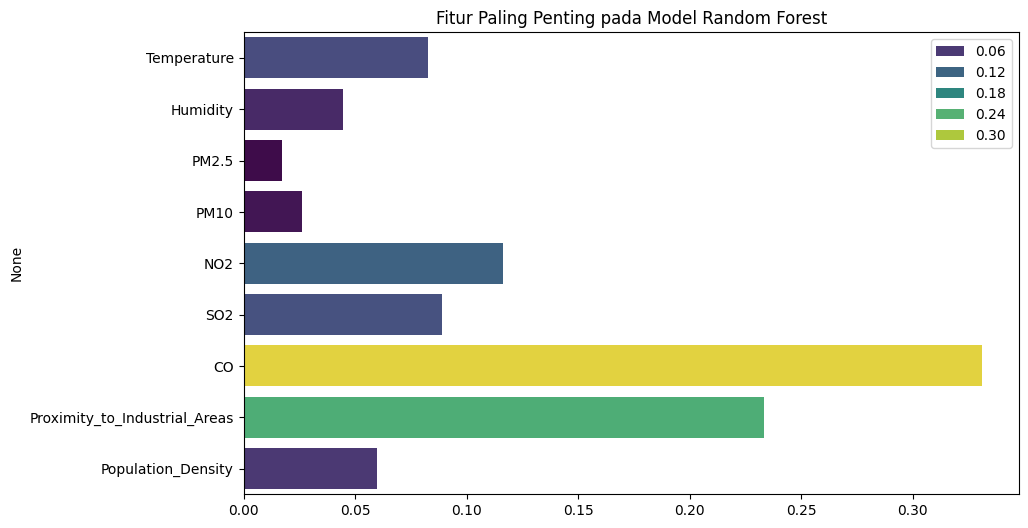

In [14]:
# Analisis Fitur Penting dengan Random Forest
feature_importance = rf_model.feature_importances_
features = X.columns

# Visualisasi pentingnya fitur
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features, palette='viridis', hue=feature_importance)
plt.title("Fitur Paling Penting pada Model Random Forest")
plt.show()


### **Hasil Evaluasi Model**

### **Feature Importance (Random Forest)**
1. **Faktor Utama:**
   - **CO (Carbon Monoxide)**: **33.09%**
   - **Proximity to Industrial Areas**: **23.35%**
   - **NO2 (Nitrogen Dioxide)**: **11.62%**
   - **SO2 (Sulfur Dioxide)**: **8.89%**

2. **Faktor Menengah:**
   - **Temperature (Suhu)**: **8.27%**
   - **Population Density (Kepadatan Penduduk)**: **5.97%**
   - **Humidity (Kelembapan)**: **4.47%**

3. **Faktor Rendah:**
   - **PM10**: **2.62%**
   - **PM2.5**: **1.70%**

---

### **Kesimpulan**
1. **Model Random Forest lebih akurat dibandingkan SVM** pada data testing (98.02% vs 94.19%), meskipun SVM lebih konsisten pada data training dan testing.
2. **Faktor paling signifikan dalam memengaruhi kualitas udara adalah:**
   - **CO** (Carbon Monoxide)
   - **Kedekatan dengan Kawasan Industri**
   - **Gas Polutan (NO2 dan SO2)**
3. **Faktor Lingkungan dan Sosial seperti Suhu, Kelembapan, dan Kepadatan Penduduk juga berkontribusi**, meskipun pengaruhnya lebih kecil dibandingkan dengan polutan utama.
4. **Partikulat PM2.5 dan PM10 memiliki kontribusi rendah dalam model ini**, namun tetap relevan untuk analisis lebih lanjut.

---

### **Rekomendasi**
1. **Pengendalian Emisi:**
   - Prioritaskan pengurangan emisi **CO, NO2, dan SO2**, khususnya di kawasan industri.
2. **Pemantauan Kualitas Udara:**
   - Fokus pada wilayah dengan **kepadatan penduduk tinggi** dan **dekat dengan kawasan industri** untuk memitigasi risiko kesehatan masyarakat.
3. **Intervensi Lingkungan:**
   - Perhitungkan **kondisi cuaca** seperti suhu dan kelembapan untuk strategi mitigasi berbasis iklim.
---
